## CSE 512 - HW 5 - Gourab Bhattacharyya - 170048888

# Sequence Classification using Recurrent Neural Networks(RNN)
In this homework, you will learn how to train a recurrent neural network for human action classification. RNN is designed handle sequential data. The network can incorporate both past history and current input. [This](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is a very good tutorial. You should read it before you start.

## Setup
**Please make sure you have h5py and torchnet installed**
> pip install h5py

> pip install git+https://github.com/pytorch/tnt.git@master

## Known Windows Issues:
### In case you're getting an error [Read more](https://discuss.pytorch.org/t/brokenpipeerror-errno-32-broken-pipe-when-i-run-cifar10-tutorial-py/6224): 
```python
BrokenPipeError: [Errno 32] Broken pipe
```

>In the dataloader block change Line 39, 42, and 45 num_workers=0 

### In case of error (This should be a CUDA error [Read more](https://discuss.pytorch.org/t/asserterror-in-lstm-layer-on-gpu/8698)):

```python
--> 186             assert param_from.type() == param_to.type()
AssertionError: 
```

**Replace following lines:**
```python
def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None):
    ...
    input_sequence_var = Variable(sequence).type(FloatTensor)
    input_label_var = Variable(label).type(LongTensor)
    ...
```
```python
def predict_on_test(model, data_loader):
    ...
        input_sequence_var = Variable(sequence).type(FloatTensor)
    ...
```
** With: **
```python
def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None):
    ...
    input_sequence_var = Variable(sequence)
    input_label_var = Variable(label)
    ...
```
```python
def predict_on_test(model, data_loader):
    ...
        input_sequence_var = Variable(sequence)
    ...
```

In [3]:
import os
import numpy as np
import h5py

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as DD
import torchnet as tnt
import torch.nn.functional as F


use_cuda = torch.cuda.is_available()
print('use cuda: %s'%(use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
print('success')

use cuda: False
success


## Dataset
The data we are using is skeleton data, which indicates the 3D locations of body joints. In total, there are 25 body joints. It is collected by Kinect v2. To make it easier, each sequence have same number of frames. You need to classify 10 different actions. There are 4000 training sequences, 800 validation sequences, and 1000 test sequences. Each sequence has 15 frames, each frame is a 75-dimension vector (3*25).

For your convenience, we provide the dataloader for you.


In [4]:
class Dataset(DD.Dataset):
    # subset can be: 'train', 'val', 'test'
    def __init__(self, data_path, subset='train'):
        super(Dataset, self).__init__()
        self.data_path = os.path.join(data_path, '%s_data.h5'%subset)
        self.subset = subset

        with h5py.File(self.data_path) as f:
            self.data = np.array(f['data'])

        if subset != 'test':
            self.label_path = os.path.join(data_path, '%s_label.h5'%subset)
            with h5py.File(self.label_path) as f:
                self.label = np.array(f['label'])

        self.num_sequences = self.data.shape[0]
        self.seq_len = self.data.shape[1]
        self.n_dim = self.data.shape[2]

    def __getitem__(self, index):
        seq = self.data[index]
        if self.subset != 'test':
            label = int(self.label[index])
            sample = {'seq': seq, 'label': label}
        else:
            sample = {'seq': seq}
        return sample

    def __len__(self):
        return self.num_sequences

trSet = Dataset('./data', subset='train')
valSet = Dataset('./data', subset='val')
tstSet = Dataset('./data', subset='test')

batch_size = 100
trLD = DD.DataLoader(trSet, batch_size=batch_size,
       sampler=DD.sampler.RandomSampler(trSet),
       num_workers=2, pin_memory=False)
valLD = DD.DataLoader(valSet, batch_size=batch_size,
       sampler=DD.sampler.SequentialSampler(valSet),
       num_workers=1, pin_memory=False)
tstLD = DD.DataLoader(tstSet, batch_size=batch_size,
       sampler=DD.sampler.SequentialSampler(tstSet),
       num_workers=1, pin_memory=False)

input_dim = trSet.n_dim
num_class = 10

## Model
Pytorch has implemented different types of recurrent layers for you. For this homework, you can use any type of RNNs as you want:
> torch.nn.RNN()

> torch.nn.LSTM()

> torch.nn.GRU()

You can check details for different types of recurrent layers here: [RNN](http://pytorch.org/docs/master/nn.html#torch.nn.RNN), [LSTM]( http://pytorch.org/docs/master/nn.html#torch.nn.LSTM), [GRU](http://pytorch.org/docs/master/nn.html#torch.nn.GRU)


### Implement a specific model
In this section, you need to implement a model for sequence classification. The model has following layers:
* 1 Layer LSTM layer with hidden size of 100, and input size of 75
* A linear layer that goes from 100 to num_class (10). 

An LSTM layer takes an input of size of (batch_size, seq_len, fea_dim) and outputs a variable of shape (batch_size, seq_len, hidden_size). In this homework, the classification score for a sequence is the classification score for the last step of rnn_outputs.



In [5]:
# sequence classification model
class SequenceClassify(nn.Module):
    def __init__(self):
        super(SequenceClassify, self).__init__()
        
        ############## 1st To Do (20 points) ##############
        ###################################################
        self.recurrent_layer = nn.LSTM(75, 100, num_layers=1)
        self.classify_layer = nn.Linear(100, 10)
        ###################################################
    
    # the size of input is [batch_size, seq_len(15), input_dim(75)]
    # the size of logits is [batch_size, num_class]
    def forward(self, input, h_t_1=None, c_t_1=None):
        # the size of rnn_outputs is [batch_size, seq_len, rnn_size]
        rnn_outputs, (hn, cn) = self.recurrent_layer(input)
        # classify the last step of rnn_outpus
        # the size of logits is [batch_size, num_class]
        logits = self.classify_layer(rnn_outputs[:,-1])
        return logits

model = SequenceClassify()

## Train the model
After you have the dataloader and model, you can start training the model. Define a SGD optimizer with learning rate of 1e-2, and a cross-entropy loss function:

In [6]:
################ 2nd To Do  (5 points)##################
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2)
criterion = nn.CrossEntropyLoss()

In [8]:
# run the model for one epoch
# can be used for both training or validation model
def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None):
    if is_training:
        model.train()
        logger_prefix = 'train'
    else:
        model.eval()
        logger_prefix = 'val'

    confusion_matrix = tnt.meter.ConfusionMeter(num_class)
    acc = tnt.meter.ClassErrorMeter(accuracy=True)
    meter_loss = tnt.meter.AverageValueMeter()

    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        label = sample['label']
        input_sequence_var = Variable(sequence).type(FloatTensor)
        input_label_var = Variable(label).type(LongTensor)
        

        # compute output
        # output_logits: [batch_size, num_class]
        output_logits = model(input_sequence_var)
        loss = criterion(output_logits, input_label_var)

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        meter_loss.add(loss.data[0])
        acc.add(output_logits.data, input_label_var.data)
        confusion_matrix.add(output_logits.data, input_label_var.data)


    print('%s Epoch: %d  , Loss: %.4f,  Accuracy: %.2f'%(logger_prefix, epoch, meter_loss.value()[0], acc.value()[0]))
    return acc.value()[0]

num_epochs = 1
evaluate_every_epoch = 2
for e in range(num_epochs):
    run_epoch(trLD, model, criterion, e, True, optimizer)
    if e % evaluate_every_epoch == 0:
        run_epoch(valLD, model, criterion, e, False, None)   



train Epoch: 0  , Loss: 2.3004,  Accuracy: 10.40
val Epoch: 0  , Loss: 2.2989,  Accuracy: 11.88


## Submit your results on Kaggle

### Train a better model for action recognition!
Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves better accuracy on the action recognition validation set.


### Testing the model and submit on Kaggle
Testing the model on the testing set and save the results as a .csv file. 
Please submitted the results.csv file generated by predict_on_test() to Kaggle(https://www.kaggle.com/c/cse512springhw5) to see how well your network performs on the test set. 
################ 3rd To Do  (30 points, the highest 3 entries get extra 10 points) ###############


## Experiment with Model - 1

hiddenSize = 500

layer = 1

dropOut = 0.5

epoch = 20

optimizer = Adam

criterion = CrossEntropyLoss()

In [20]:
# sequence classification model
class MySequenceClassify1(nn.Module):
    def __init__(self):
        super(MySequenceClassify1, self).__init__()
        
        ###################################################
        self.recurrent_layer = nn.LSTM(75, 500, num_layers=1, dropout=0.5)
        self.classify_layer = nn.Linear(500, 10)
        self.drop = nn.Dropout(0.5)
        
        self.h_t_1 = Variable(torch.randn(1, 15, 500))
        self.c_t_1 = Variable(torch.randn(1, 15, 500))
        ###################################################
    
    # the size of input is [batch_size, seq_len(15), input_dim(75)]
    # the size of logits is [batch_size, num_class]
    def forward(self, input, h_t_1=None, c_t_1=None):
        
        h_t_1 = self.h_t_1
        c_t_1 = self.c_t_1
        # the size of rnn_outputs is [batch_size, seq_len, rnn_size]
        rnn_outputs, (hn, cn) = self.recurrent_layer(input, (h_t_1, c_t_1))
        # classify the last step of rnn_outpus
        # the size of logits is [batch_size, num_class]
        h_t_1 = hn
        c_t_1 = cn
        rnn_outputs = self.drop(rnn_outputs)
        
        logits = self.classify_layer(rnn_outputs[:,-1])
        
        return logits

myModel1 = MySequenceClassify1()

myOptimizer1 = torch.optim.Adam(myModel1.parameters(), lr = 1e-3)
myCriterion1 = nn.CrossEntropyLoss()

num_epochs = 20
evaluate_every_epoch = 2
for e in range(num_epochs):
    run_epoch(trLD, myModel1, myCriterion1, e, True, myOptimizer1)
    if e % evaluate_every_epoch == 0:
        run_epoch(valLD, myModel1, myCriterion1, e, False, None)

train Epoch: 0  , Loss: 2.3079,  Accuracy: 11.52
val Epoch: 0  , Loss: 2.2638,  Accuracy: 19.25
train Epoch: 1  , Loss: 2.2174,  Accuracy: 18.15
train Epoch: 2  , Loss: 2.0571,  Accuracy: 23.50
val Epoch: 2  , Loss: 1.9216,  Accuracy: 28.37
train Epoch: 3  , Loss: 1.9240,  Accuracy: 26.68
train Epoch: 4  , Loss: 1.8512,  Accuracy: 29.75
val Epoch: 4  , Loss: 1.8026,  Accuracy: 29.62
train Epoch: 5  , Loss: 1.8387,  Accuracy: 29.73
train Epoch: 6  , Loss: 1.8038,  Accuracy: 31.90
val Epoch: 6  , Loss: 1.7507,  Accuracy: 36.75
train Epoch: 7  , Loss: 1.8018,  Accuracy: 30.95
train Epoch: 8  , Loss: 1.7790,  Accuracy: 32.30
val Epoch: 8  , Loss: 1.7166,  Accuracy: 35.62
train Epoch: 9  , Loss: 1.7731,  Accuracy: 31.80
train Epoch: 10  , Loss: 1.7722,  Accuracy: 33.15
val Epoch: 10  , Loss: 1.7201,  Accuracy: 36.25
train Epoch: 11  , Loss: 1.7769,  Accuracy: 32.25
train Epoch: 12  , Loss: 1.7621,  Accuracy: 33.60
val Epoch: 12  , Loss: 1.7342,  Accuracy: 33.25
train Epoch: 13  , Loss: 1.75

## Experiment with Model - 2

hiddenSize = 500

layer = 3

dropOut = 0.5

epoch = 22

optimizer = Adam

criterion = CrossEntropyLoss()

In [22]:
# sequence classification model
class MySequenceClassify2(nn.Module):
    def __init__(self):
        super(MySequenceClassify2, self).__init__()
        
        ###################################################
        self.recurrent_layer = nn.LSTM(75, 500, num_layers=3, dropout=0.5)
        self.classify_layer = nn.Linear(500, 10)
        self.drop = nn.Dropout(0.5)
        
        self.h_t_1 = Variable(torch.randn(3, 15, 500))
        self.c_t_1 = Variable(torch.randn(3, 15, 500))
        ###################################################
    
    # the size of input is [batch_size, seq_len(15), input_dim(75)]
    # the size of logits is [batch_size, num_class]
    def forward(self, input, h_t_1=None, c_t_1=None):
        
        h_t_1 = self.h_t_1
        c_t_1 = self.c_t_1
        # the size of rnn_outputs is [batch_size, seq_len, rnn_size]
        rnn_outputs, (hn, cn) = self.recurrent_layer(input, (h_t_1, c_t_1))
        # classify the last step of rnn_outpus
        # the size of logits is [batch_size, num_class]
        h_t_1 = hn
        c_t_1 = cn
        rnn_outputs = self.drop(rnn_outputs)
        
        logits = self.classify_layer(rnn_outputs[:,-1])
        
        return logits

myModel2 = MySequenceClassify2()

myOptimizer2 = torch.optim.Adam(myModel2.parameters(), lr = 1e-3)
myCriterion2 = nn.CrossEntropyLoss()

num_epochs = 22
evaluate_every_epoch = 2
for e in range(num_epochs):
    run_epoch(trLD, myModel2, myCriterion2, e, True, myOptimizer2)
    if e % evaluate_every_epoch == 0:
        run_epoch(valLD, myModel2, myCriterion2, e, False, None)

train Epoch: 0  , Loss: 2.3119,  Accuracy: 9.75
val Epoch: 0  , Loss: 2.3089,  Accuracy: 11.12
train Epoch: 1  , Loss: 2.3063,  Accuracy: 10.38
train Epoch: 2  , Loss: 2.3038,  Accuracy: 10.72
val Epoch: 2  , Loss: 2.2876,  Accuracy: 13.38
train Epoch: 3  , Loss: 2.2245,  Accuracy: 15.48
train Epoch: 4  , Loss: 2.0738,  Accuracy: 18.77
val Epoch: 4  , Loss: 1.9664,  Accuracy: 21.88
train Epoch: 5  , Loss: 1.9993,  Accuracy: 21.27
train Epoch: 6  , Loss: 1.9304,  Accuracy: 24.75
val Epoch: 6  , Loss: 1.8643,  Accuracy: 28.37
train Epoch: 7  , Loss: 1.8745,  Accuracy: 27.18
train Epoch: 8  , Loss: 1.8390,  Accuracy: 28.43
val Epoch: 8  , Loss: 1.7423,  Accuracy: 33.38
train Epoch: 9  , Loss: 1.8104,  Accuracy: 28.65
train Epoch: 10  , Loss: 1.8104,  Accuracy: 29.55
val Epoch: 10  , Loss: 1.7590,  Accuracy: 31.00
train Epoch: 11  , Loss: 1.7970,  Accuracy: 29.27
train Epoch: 12  , Loss: 1.7948,  Accuracy: 30.60
val Epoch: 12  , Loss: 1.7353,  Accuracy: 34.38
train Epoch: 13  , Loss: 1.759

## Experiment with Model - 3

hiddenSize = 500

layer = 1

dropOut = 0.5

logits = log_softmax

epoch = 42

optimizer = Adam

criterion = NLLLoss()

In [24]:
# sequence classification model
class MySequenceClassify4(nn.Module):
    def __init__(self):
        super(MySequenceClassify4, self).__init__()
        
        ###################################################
        self.recurrent_layer = nn.LSTM(75, 500, num_layers=1, dropout=0.5)
        self.classify_layer = nn.Linear(500, 10)
        self.drop = nn.Dropout(0.5)
        
        self.h_t_1 = Variable(torch.randn(1, 15, 500))
        self.c_t_1 = Variable(torch.randn(1, 15, 500))
        ###################################################
    
    # the size of input is [batch_size, seq_len(15), input_dim(75)]
    # the size of logits is [batch_size, num_class]
    def forward(self, input, h_t_1=None, c_t_1=None):
        
        h_t_1 = self.h_t_1
        c_t_1 = self.c_t_1
        # the size of rnn_outputs is [batch_size, seq_len, rnn_size]
        rnn_outputs, (hn, cn) = self.recurrent_layer(input, (h_t_1, c_t_1))
        # classify the last step of rnn_outpus
        # the size of logits is [batch_size, num_class]
        #h_t_1 = hn
        #c_t_1 = cn
        rnn_outputs = self.drop(rnn_outputs)
        
        logits = self.classify_layer(rnn_outputs[:,-1])
        
        log_probs = F.log_softmax(logits, dim = -1)
        
        return log_probs#logits

myModel4 = MySequenceClassify4()

myOptimizer4 = torch.optim.Adam(myModel4.parameters(), lr = 1e-3)
myCriterion4 = nn.NLLLoss()#nn.CrossEntropyLoss()

num_epochs = 42
evaluate_every_epoch = 2
for e in range(num_epochs):
    run_epoch(trLD, myModel4, myCriterion4, e, True, myOptimizer4)
    if e % evaluate_every_epoch == 0:
        run_epoch(valLD, myModel4, myCriterion4, e, False, None)

train Epoch: 0  , Loss: 2.3025,  Accuracy: 11.98
val Epoch: 0  , Loss: 2.2602,  Accuracy: 14.38
train Epoch: 1  , Loss: 2.2170,  Accuracy: 18.23
train Epoch: 2  , Loss: 2.0873,  Accuracy: 22.62
val Epoch: 2  , Loss: 1.9683,  Accuracy: 28.25
train Epoch: 3  , Loss: 1.9304,  Accuracy: 26.35
train Epoch: 4  , Loss: 1.8657,  Accuracy: 28.08
val Epoch: 4  , Loss: 1.7734,  Accuracy: 36.75
train Epoch: 5  , Loss: 1.8279,  Accuracy: 29.77
train Epoch: 6  , Loss: 1.8103,  Accuracy: 30.93
val Epoch: 6  , Loss: 1.7754,  Accuracy: 33.00
train Epoch: 7  , Loss: 1.8033,  Accuracy: 31.40
train Epoch: 8  , Loss: 1.7856,  Accuracy: 32.23
val Epoch: 8  , Loss: 1.7438,  Accuracy: 36.50
train Epoch: 9  , Loss: 1.7762,  Accuracy: 31.07
train Epoch: 10  , Loss: 1.7657,  Accuracy: 32.20
val Epoch: 10  , Loss: 1.7091,  Accuracy: 34.13
train Epoch: 11  , Loss: 1.7693,  Accuracy: 33.38
train Epoch: 12  , Loss: 1.7511,  Accuracy: 34.17
val Epoch: 12  , Loss: 1.7040,  Accuracy: 34.13
train Epoch: 13  , Loss: 1.75

## Experiment with Model - 4

hiddenSize = 600

layer = 1

dropOut = 0.5

epoch = 502

optimizer = Adam

criterion = CrossEntropyLoss

In [15]:
# sequence classification model
class MySequenceClassify5(nn.Module):
    def __init__(self):
        super(MySequenceClassify5, self).__init__()
        
        ###################################################
        self.recurrent_layer = nn.LSTM(75, 600, num_layers=1, dropout=0.5)
        self.classify_layer = nn.Linear(600, 10)
        self.drop = nn.Dropout(0.5)
        
        self.h_t_1 = Variable(torch.randn(1, 15, 600))
        self.c_t_1 = Variable(torch.randn(1, 15, 600))
        ###################################################
    
    # the size of input is [batch_size, seq_len(15), input_dim(75)]
    # the size of logits is [batch_size, num_class]
    def forward(self, input, h_t_1=None, c_t_1=None):
        
        h_t_1 = self.h_t_1
        c_t_1 = self.c_t_1
        # the size of rnn_outputs is [batch_size, seq_len, rnn_size]
        rnn_outputs, (hn, cn) = self.recurrent_layer(input, (h_t_1, c_t_1))
        # classify the last step of rnn_outpus
        # the size of logits is [batch_size, num_class]
        rnn_outputs = self.drop(rnn_outputs)
        
        logits = self.classify_layer(rnn_outputs[:,-1])
        
        return logits#log_probs

myModel5 = MySequenceClassify5()

myOptimizer5 = torch.optim.Adam(myModel5.parameters(), lr = 1e-3)
myCriterion5 = nn.CrossEntropyLoss()#nn.NLLLoss()#nn.CrossEntropyLoss()

num_epochs = 502
evaluate_every_epoch = 50
for e in range(num_epochs):
    run_epoch(trLD, myModel5, myCriterion5, e, True, myOptimizer5)
    if e % evaluate_every_epoch == 0:
        run_epoch(valLD, myModel5, myCriterion5, e, False, None)


torch.save(myModel5, 'filename_myModel5.pt')

train Epoch: 0  , Loss: 2.3035,  Accuracy: 12.05
val Epoch: 0  , Loss: 2.2516,  Accuracy: 15.00
train Epoch: 1  , Loss: 2.2131,  Accuracy: 17.23
train Epoch: 2  , Loss: 2.0328,  Accuracy: 23.85
train Epoch: 3  , Loss: 1.9043,  Accuracy: 27.12
train Epoch: 4  , Loss: 1.8553,  Accuracy: 29.53
train Epoch: 5  , Loss: 1.8251,  Accuracy: 30.15
train Epoch: 6  , Loss: 1.8130,  Accuracy: 32.17
train Epoch: 7  , Loss: 1.8073,  Accuracy: 30.85
train Epoch: 8  , Loss: 1.7872,  Accuracy: 30.93
train Epoch: 9  , Loss: 1.7686,  Accuracy: 31.85
train Epoch: 10  , Loss: 1.7676,  Accuracy: 33.05
train Epoch: 11  , Loss: 1.7715,  Accuracy: 32.85
train Epoch: 12  , Loss: 1.7548,  Accuracy: 33.30
train Epoch: 13  , Loss: 1.7593,  Accuracy: 33.60
train Epoch: 14  , Loss: 1.7388,  Accuracy: 33.80
train Epoch: 15  , Loss: 1.7451,  Accuracy: 33.83
train Epoch: 16  , Loss: 1.7450,  Accuracy: 33.27
train Epoch: 17  , Loss: 1.7254,  Accuracy: 34.45
train Epoch: 18  , Loss: 1.7198,  Accuracy: 33.85
train Epoch: 

train Epoch: 160  , Loss: 1.4603,  Accuracy: 44.88
train Epoch: 161  , Loss: 1.4584,  Accuracy: 44.57
train Epoch: 162  , Loss: 1.4513,  Accuracy: 46.23
train Epoch: 163  , Loss: 1.4498,  Accuracy: 45.27
train Epoch: 164  , Loss: 1.4587,  Accuracy: 43.85
train Epoch: 165  , Loss: 1.4451,  Accuracy: 46.17
train Epoch: 166  , Loss: 1.4664,  Accuracy: 44.83
train Epoch: 167  , Loss: 1.4492,  Accuracy: 46.00
train Epoch: 168  , Loss: 1.4525,  Accuracy: 45.60
train Epoch: 169  , Loss: 1.4448,  Accuracy: 45.67
train Epoch: 170  , Loss: 1.4434,  Accuracy: 46.15
train Epoch: 171  , Loss: 1.4420,  Accuracy: 45.50
train Epoch: 172  , Loss: 1.4503,  Accuracy: 45.40
train Epoch: 173  , Loss: 1.4474,  Accuracy: 45.73
train Epoch: 174  , Loss: 1.4497,  Accuracy: 45.70
train Epoch: 175  , Loss: 1.4382,  Accuracy: 45.77
train Epoch: 176  , Loss: 1.4456,  Accuracy: 44.93
train Epoch: 177  , Loss: 1.4544,  Accuracy: 44.77
train Epoch: 178  , Loss: 1.4432,  Accuracy: 45.53
train Epoch: 179  , Loss: 1.436

train Epoch: 318  , Loss: 1.3088,  Accuracy: 51.60
train Epoch: 319  , Loss: 1.3264,  Accuracy: 50.55
train Epoch: 320  , Loss: 1.3277,  Accuracy: 50.28
train Epoch: 321  , Loss: 1.3178,  Accuracy: 50.30
train Epoch: 322  , Loss: 1.3353,  Accuracy: 49.92
train Epoch: 323  , Loss: 1.3311,  Accuracy: 50.15
train Epoch: 324  , Loss: 1.3204,  Accuracy: 50.28
train Epoch: 325  , Loss: 1.3251,  Accuracy: 50.85
train Epoch: 326  , Loss: 1.3154,  Accuracy: 50.48
train Epoch: 327  , Loss: 1.3264,  Accuracy: 50.08
train Epoch: 328  , Loss: 1.3265,  Accuracy: 50.37
train Epoch: 329  , Loss: 1.3091,  Accuracy: 50.55
train Epoch: 330  , Loss: 1.3271,  Accuracy: 50.45
train Epoch: 331  , Loss: 1.3297,  Accuracy: 50.85
train Epoch: 332  , Loss: 1.3143,  Accuracy: 51.17
train Epoch: 333  , Loss: 1.3214,  Accuracy: 50.50
train Epoch: 334  , Loss: 1.3277,  Accuracy: 50.40
train Epoch: 335  , Loss: 1.3033,  Accuracy: 51.23
train Epoch: 336  , Loss: 1.3153,  Accuracy: 51.55
train Epoch: 337  , Loss: 1.316

train Epoch: 476  , Loss: 1.2212,  Accuracy: 53.97
train Epoch: 477  , Loss: 1.2192,  Accuracy: 54.23
train Epoch: 478  , Loss: 1.2281,  Accuracy: 54.50
train Epoch: 479  , Loss: 1.2189,  Accuracy: 54.68
train Epoch: 480  , Loss: 1.2284,  Accuracy: 54.88
train Epoch: 481  , Loss: 1.2256,  Accuracy: 54.12
train Epoch: 482  , Loss: 1.2052,  Accuracy: 54.50
train Epoch: 483  , Loss: 1.2220,  Accuracy: 54.40
train Epoch: 484  , Loss: 1.2293,  Accuracy: 53.40
train Epoch: 485  , Loss: 1.2076,  Accuracy: 55.05
train Epoch: 486  , Loss: 1.2190,  Accuracy: 54.57
train Epoch: 487  , Loss: 1.2110,  Accuracy: 55.28
train Epoch: 488  , Loss: 1.2094,  Accuracy: 54.60
train Epoch: 489  , Loss: 1.2333,  Accuracy: 53.90
train Epoch: 490  , Loss: 1.2359,  Accuracy: 53.28
train Epoch: 491  , Loss: 1.2208,  Accuracy: 53.62
train Epoch: 492  , Loss: 1.2017,  Accuracy: 54.70
train Epoch: 493  , Loss: 1.2073,  Accuracy: 55.33
train Epoch: 494  , Loss: 1.2088,  Accuracy: 54.65
train Epoch: 495  , Loss: 1.211

/usr/local/lib/python2.7/dist-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type MySequenceClassify5. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Best Model
## Experiment with Model - 5

hiddenSize = 200

layers = 1

epoch = 402

optimizer = Adam

criterion = NLLLoss()

In [9]:
# sequence classification model
class SequenceClassify6(nn.Module):
    def __init__(self):
        super(SequenceClassify6, self).__init__()
        
        ###################################################
        self.recurrent_layer = nn.LSTM(75, 200, num_layers=1, batch_first=True)
        self.hidden = self.init_hidden(100, 200)
        self.classify_layer = nn.Linear(200, 10)
        ###################################################
    
    # the size of input is [batch_size, seq_len(15), input_dim(75)]
    # the size of logits is [batch_size, num_class]
    
    def init_hidden(self, hid_size, batch_size):
        return(Variable(torch.randn(1, hid_size, batch_size)),
               Variable(torch.randn(1, hid_size, batch_size)))
    
    def forward(self, input, h_t_1=None, c_t_1=None):
        # the size of rnn_outputs is [batch_size, seq_len, rnn_size]
        rnn_outputs, (hn, cn) = self.recurrent_layer(input, self.hidden)
        # classify the last step of rnn_outpus
        # the size of logits is [batch_size, num_class]
        logits = self.classify_layer(rnn_outputs[:,-1])
        
        log_probs = F.log_softmax(logits, dim = -1)
        
        #return logits
        return log_probs

model6 = SequenceClassify6()

myOptimizer6 = torch.optim.Adam(model6.parameters(), lr = 1e-3)
myCriterion6 = nn.NLLLoss()

num_epochs = 402
evaluate_every_epoch = 50
for e in range(num_epochs):
    run_epoch(trLD, model6, myCriterion6, e, True, myOptimizer6)
    if e % evaluate_every_epoch == 0:
        run_epoch(valLD, model6, myCriterion6, e, False, None)

train Epoch: 0  , Loss: 2.1730,  Accuracy: 19.17
val Epoch: 0  , Loss: 1.8477,  Accuracy: 29.37
train Epoch: 1  , Loss: 1.5673,  Accuracy: 43.00
train Epoch: 2  , Loss: 1.2080,  Accuracy: 57.55
train Epoch: 3  , Loss: 1.0731,  Accuracy: 61.22
train Epoch: 4  , Loss: 0.9575,  Accuracy: 65.38
train Epoch: 5  , Loss: 0.8837,  Accuracy: 68.38
train Epoch: 6  , Loss: 0.8383,  Accuracy: 69.25
train Epoch: 7  , Loss: 0.7635,  Accuracy: 73.20
train Epoch: 8  , Loss: 0.7192,  Accuracy: 74.52
train Epoch: 9  , Loss: 0.7038,  Accuracy: 75.00
train Epoch: 10  , Loss: 0.6768,  Accuracy: 75.40
train Epoch: 11  , Loss: 0.6473,  Accuracy: 77.20
train Epoch: 12  , Loss: 0.6341,  Accuracy: 77.42
train Epoch: 13  , Loss: 0.6120,  Accuracy: 78.40
train Epoch: 14  , Loss: 0.5808,  Accuracy: 79.00
train Epoch: 15  , Loss: 0.5744,  Accuracy: 79.28
train Epoch: 16  , Loss: 0.5430,  Accuracy: 80.53
train Epoch: 17  , Loss: 0.5293,  Accuracy: 81.05
train Epoch: 18  , Loss: 0.5306,  Accuracy: 81.20
train Epoch: 

train Epoch: 159  , Loss: 0.0265,  Accuracy: 99.17
train Epoch: 160  , Loss: 0.0565,  Accuracy: 98.00
train Epoch: 161  , Loss: 0.0538,  Accuracy: 98.15
train Epoch: 162  , Loss: 0.0322,  Accuracy: 99.17
train Epoch: 163  , Loss: 0.0408,  Accuracy: 98.83
train Epoch: 164  , Loss: 0.0473,  Accuracy: 98.45
train Epoch: 165  , Loss: 0.0644,  Accuracy: 97.80
train Epoch: 166  , Loss: 0.0614,  Accuracy: 97.88
train Epoch: 167  , Loss: 0.0389,  Accuracy: 98.88
train Epoch: 168  , Loss: 0.0594,  Accuracy: 97.95
train Epoch: 169  , Loss: 0.0426,  Accuracy: 98.60
train Epoch: 170  , Loss: 0.0245,  Accuracy: 99.22
train Epoch: 171  , Loss: 0.0229,  Accuracy: 99.30
train Epoch: 172  , Loss: 0.0201,  Accuracy: 99.50
train Epoch: 173  , Loss: 0.0120,  Accuracy: 99.62
train Epoch: 174  , Loss: 0.0137,  Accuracy: 99.67
train Epoch: 175  , Loss: 0.0165,  Accuracy: 99.58
train Epoch: 176  , Loss: 0.0099,  Accuracy: 99.85
train Epoch: 177  , Loss: 0.0054,  Accuracy: 99.92
train Epoch: 178  , Loss: 0.014

train Epoch: 317  , Loss: 0.0010,  Accuracy: 99.98
train Epoch: 318  , Loss: 0.0005,  Accuracy: 100.00
train Epoch: 319  , Loss: 0.0004,  Accuracy: 100.00
train Epoch: 320  , Loss: 0.0004,  Accuracy: 100.00
train Epoch: 321  , Loss: 0.0004,  Accuracy: 100.00
train Epoch: 322  , Loss: 0.0003,  Accuracy: 100.00
train Epoch: 323  , Loss: 0.0003,  Accuracy: 100.00
train Epoch: 324  , Loss: 0.0003,  Accuracy: 100.00
train Epoch: 325  , Loss: 0.0003,  Accuracy: 100.00
train Epoch: 326  , Loss: 0.0003,  Accuracy: 100.00
train Epoch: 327  , Loss: 0.0002,  Accuracy: 100.00
train Epoch: 328  , Loss: 0.0002,  Accuracy: 100.00
train Epoch: 329  , Loss: 0.0002,  Accuracy: 100.00
train Epoch: 330  , Loss: 0.0002,  Accuracy: 100.00
train Epoch: 331  , Loss: 0.0005,  Accuracy: 99.98
train Epoch: 332  , Loss: 0.0007,  Accuracy: 100.00
train Epoch: 333  , Loss: 0.0003,  Accuracy: 100.00
train Epoch: 334  , Loss: 0.0002,  Accuracy: 100.00
train Epoch: 335  , Loss: 0.0002,  Accuracy: 100.00
train Epoch: 3

In [10]:
# Use your best model to generate results on test set.

# generate csv file for test set
def predict_on_test(model, data_loader):
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    results=open('results.csv','w')
    count=0
    results.write('Id'+','+'Class'+'\n')
    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        input_sequence_var = Variable(sequence).type(FloatTensor)
        scores = model(input_sequence_var)
        _, preds = scores.data.max(1)
        for i in range(len(preds)):
            results.write(str(count)+','+str(preds[i])+'\n')
            count+=1
    results.close()
    return count

count=predict_on_test(model6, tstLD)
print(count)

1000


## Report the performance
################ 4th To Do  (15 points)##################

### Documentation of what you did
In this cell, you should write an explanation of what you did (network architecture, optimiziter, learning rate, epoches) and visualizations or graphs of loss/accuracy curve tin the process of training and evaluating.

### performance on Kaggle
You should also report your Kaggle Performance here:

1.The basic architecture I am forllowing is like LSTM-->hidden layer-->linear layer

2.Then I am using forward function which is being called from the model traing method and get the loss for each epoch during traing, validation and generate prediction at each epoch during traing and validation.

3.I have done 5 experiments with the below configuration:

configuration1:
--------------
hiddenSize = 500

layer = 1

dropOut = 0.5

epoch = 20

optimizer = Adam

criterion = CrossEntropyLoss()





configuration2:
--------------
hiddenSize = 500

layer = 3

dropOut = 0.5

epoch = 22

optimizer = Adam

criterion = CrossEntropyLoss()





configuration3:
--------------
hiddenSize = 500

layer = 1

dropOut = 0.5

logits = log_softmax

epoch = 42

optimizer = Adam

criterion = NLLLoss()




configuration4:
--------------
hiddenSize = 600

layer = 1

dropOut = 0.5

epoch = 502

optimizer = Adam

criterion = CrossEntropyLoss




configuration5 (Best Model):
-------------------------
hiddenSize = 200

layers = 1

epoch = 402

optimizer = Adam

criterion = NLLLoss()



4.I have generated the results.csv file and uploaded the same in the Kaggle with the name of 'gourabbhattacharyya' and got accuracy value of 0.80600


5.The loss/accuracy curve for traing and validation is shown below.

## Error and Accuracy plot for training and validation for the best model

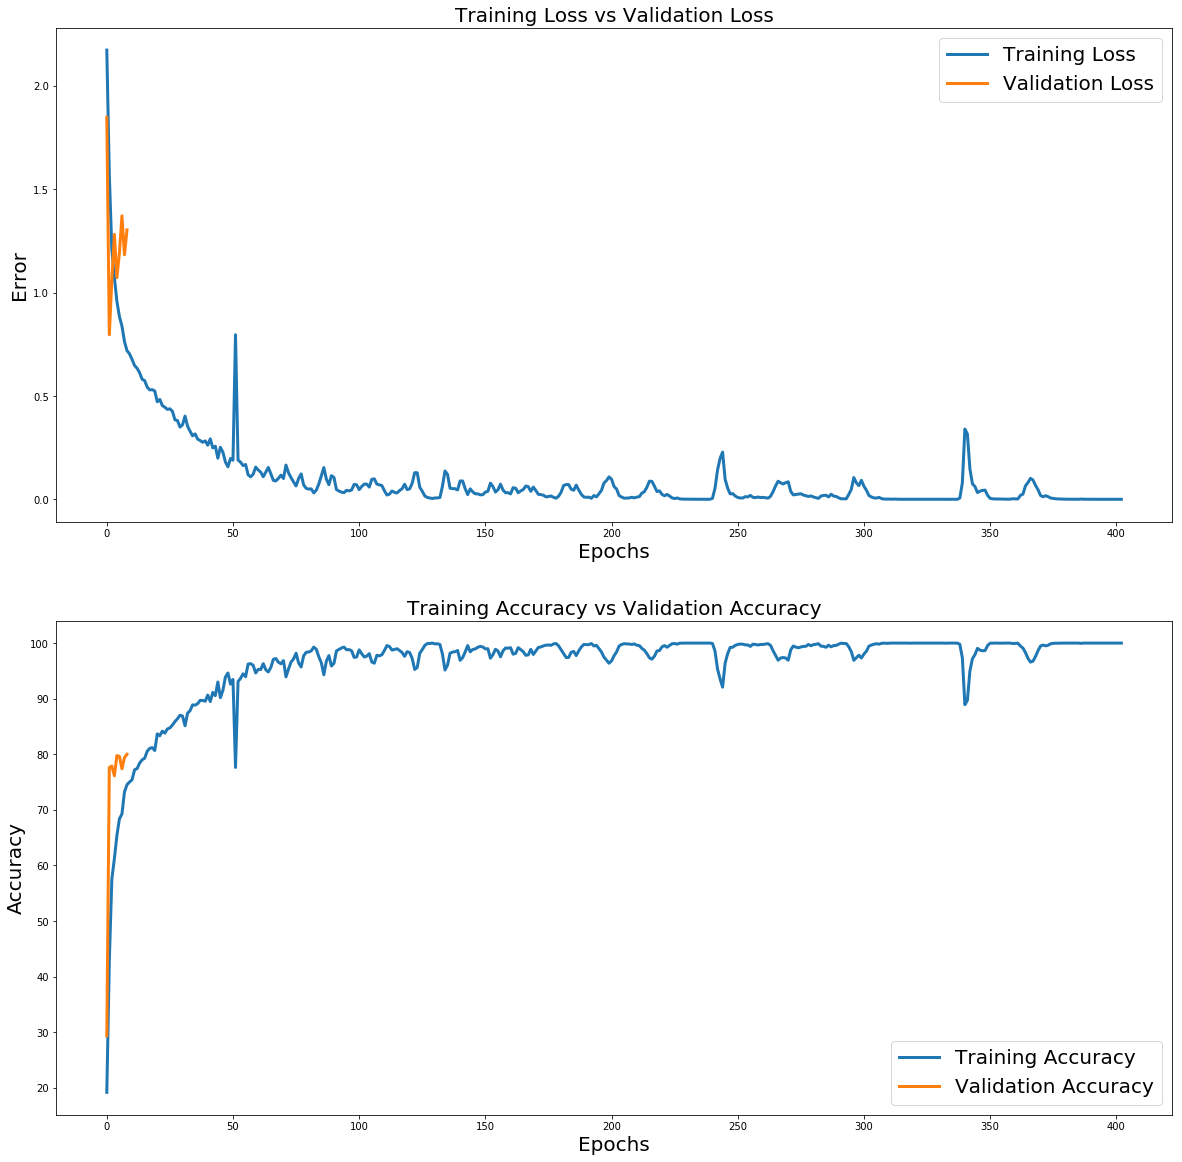

In [22]:
import matplotlib
import matplotlib.pyplot as plt

trainLoss = [2.173,1.5673,1.208,1.0731,0.9575,0.8837,0.8383,0.7635,0.7192,0.7038,0.6768,0.6473,0.6341,0.612,0.5808,0.5744,0.543,0.5293,0.5306,0.5243,0.4718,0.4833,0.4536,0.4457,0.4351,0.4379,0.426,0.3847,0.3813,0.3496,0.3604,0.4026,0.3542,0.3292,0.3072,0.3167,0.2915,0.2843,0.2762,0.2828,0.2618,0.2927,0.249,0.2571,0.1991,0.252,0.2283,0.1806,0.1574,0.1971,0.1894,0.7962,0.1903,0.1799,0.1633,0.1685,0.1187,0.1089,0.1217,0.156,0.142,0.1314,0.1094,0.1314,0.1542,0.1236,0.0915,0.0892,0.1019,0.1172,0.1008,0.1658,0.1285,0.1053,0.0842,0.0648,0.1009,0.123,0.07,0.0533,0.0496,0.0507,0.0313,0.0442,0.0742,0.1148,0.1538,0.0978,0.0711,0.1146,0.1064,0.0474,0.0401,0.0352,0.0325,0.0437,0.0409,0.0454,0.0723,0.0703,0.047,0.0623,0.0736,0.0738,0.0592,0.097,0.0992,0.0739,0.0705,0.0666,0.0417,0.021,0.0254,0.0403,0.0338,0.0307,0.0428,0.0513,0.0731,0.0474,0.0507,0.0779,0.129,0.1287,0.0588,0.0394,0.0165,0.0092,0.0067,0.0041,0.0068,0.0069,0.0089,0.0639,0.1372,0.121,0.0538,0.0519,0.0513,0.0457,0.089,0.0887,0.0517,0.0228,0.0508,0.0361,0.027,0.0267,0.0217,0.0228,0.0351,0.0389,0.0784,0.0622,0.0353,0.0464,0.0736,0.0449,0.032,0.0325,0.0265,0.0565,0.0538,0.0322,0.0408,0.0473,0.0644,0.0614,0.0389,0.0594,0.0426,0.0245,0.0229,0.0201,0.012,0.0137,0.0165,0.0099,0.0054,0.0149,0.034,0.0671,0.0713,0.0715,0.0492,0.044,0.069,0.0453,0.0246,0.0116,0.0099,0.0107,0.0051,0.0186,0.012,0.0267,0.0436,0.0789,0.0911,0.1087,0.0972,0.0623,0.0496,0.0182,0.0111,0.0056,0.006,0.0069,0.0099,0.0074,0.0108,0.0132,0.0301,0.0371,0.0585,0.0881,0.0869,0.0636,0.0379,0.0411,0.0238,0.0174,0.0238,0.0158,0.0071,0.0038,0.0067,0.0025,0.0012,0.0009,0.0007,0.0008,0.0006,0.0006,0.0005,0.0005,0.0005,0.0004,0.0004,0.0004,0.0052,0.0543,0.1423,0.198,0.2285,0.0972,0.0541,0.0264,0.0278,0.0161,0.0092,0.0067,0.0064,0.0133,0.0117,0.0191,0.0099,0.0085,0.0112,0.0086,0.0098,0.0078,0.0059,0.0147,0.0375,0.0652,0.0876,0.08,0.0743,0.0807,0.0849,0.0388,0.0216,0.0236,0.0258,0.0272,0.0208,0.0176,0.0138,0.0167,0.0114,0.008,0.0047,0.0162,0.019,0.0199,0.0116,0.0251,0.0157,0.014,0.0073,0.0027,0.0029,0.0027,0.0239,0.0483,0.1055,0.0798,0.0668,0.0923,0.0636,0.0439,0.0187,0.0114,0.007,0.0064,0.0095,0.0037,0.0013,0.0015,0.0013,0.0007,0.0014,0.0007,0.0005,0.0005,0.0004,0.0007,0.001,0.0005,0.0004,0.0004,0.0004,0.0003,0.0003,0.0003,0.0003,0.0003,0.0002,0.0002,0.0002,0.0002,0.0005,0.0007,0.0003,0.0002,0.0002,0.0004,0.006,0.0796,0.34,0.316,0.1469,0.0752,0.0617,0.0329,0.0397,0.0434,0.0448,0.0197,0.0051,0.0025,0.0018,0.0016,0.0017,0.0012,0.001,0.001,0.0008,0.003,0.0022,0.0021,0.0194,0.0252,0.0653,0.0812,0.1016,0.0935,0.067,0.0462,0.0185,0.0126,0.0177,0.0129,0.0062,0.0048,0.0026,0.0021,0.0012,0.0008,0.0008,0.0008,0.0006,0.0006,0.0006,0.0005,0.0015,0.0007,0.0005,0.0005,0.0004,0.0004,0.0004,0.0003,0.0003,0.0003,0.0004,0.0003,0.0003,0.0003,0.0003,0.0003,0.0003]
valLoss = [1.8477,0.7962,1.0641,1.2817,1.0722,1.1908,1.3713,1.1827,1.303]

trainAccuracy = [19.17,43,57.55,61.22,65.38,68.38,69.25,73.2,74.52,75,75.4,77.2,77.42,78.4,79,79.28,80.53,81.05,81.2,80.67,83.67,83.33,84.15,83.8,84.55,84.73,85.25,85.88,86.38,87.02,86.88,85.12,87.38,87.85,88.88,88.83,89.1,89.7,89.68,89.53,90.65,89.48,91.12,90.53,93,90.18,91.5,93.9,94.62,92.62,93.45,77.62,93.08,93.65,94.47,93.95,96.23,96.3,96,94.62,95.28,95.25,96.3,95.2,94.8,95.62,97.08,97.22,96.55,96.28,96.85,93.92,95.33,96.58,97.15,98.17,96.43,95.7,97.7,98.35,98.4,98.58,99.28,98.9,97.55,96.47,94.3,96.75,97.75,95.88,96.35,98.6,98.85,99.12,99.28,98.8,98.83,98.62,97.42,97.5,98.78,98.1,97.5,97.65,98.1,96.6,96.38,97.8,97.7,97.9,98.67,99.55,99.38,98.75,98.85,98.98,98.67,98.3,97.62,98.45,98.3,97.25,95.25,95.62,98.17,98.83,99.58,99.92,99.92,100,99.85,99.88,99.75,98,95.15,96.03,98.17,98.38,98.45,98.67,96.9,97.38,98.4,99.55,98.42,98.85,98.95,99.25,99.4,99.3,98.95,98.98,97.28,97.92,98.88,98.58,97.52,98.6,99.12,99.08,99.17,98,98.15,99.17,98.83,98.45,97.8,97.88,98.88,97.95,98.6,99.22,99.3,99.5,99.62,99.67,99.58,99.85,99.92,99.52,98.8,98.12,97.4,97.42,98.35,98.5,97.75,98.6,99.28,99.75,99.72,99.72,99.92,99.48,99.6,99.02,98.4,97.47,96.92,96.38,96.8,97.72,98.42,99.48,99.75,99.88,99.85,99.83,99.75,99.85,99.62,99.55,99.05,98.72,98.1,97.35,97.1,97.65,98.58,98.65,99.33,99.55,99.25,99.58,99.88,99.92,99.8,99.98,100,100,100,100,100,100,100,100,100,100,100,100,99.92,98.55,95.3,93.55,92.07,96.38,98.08,99.22,99.25,99.58,99.75,99.83,99.8,99.67,99.67,99.4,99.8,99.75,99.65,99.75,99.75,99.83,99.9,99.58,98.62,97.78,96.92,97.32,97.4,97.32,96.92,98.78,99.48,99.28,99.15,99.3,99.4,99.42,99.75,99.52,99.72,99.78,99.88,99.45,99.4,99.25,99.62,99.33,99.55,99.58,99.8,99.98,99.92,99.92,99.33,98.45,96.9,97.35,97.82,97.32,98.02,98.55,99.45,99.65,99.8,99.88,99.8,99.95,100,99.95,99.98,100,100,100,100,100,100,100,99.98,100,100,100,100,100,100,100,100,100,100,100,100,100,99.98,100,100,100,100,100,99.78,97.35,88.92,89.7,95,97.2,97.92,99.05,98.72,98.62,98.65,99.55,99.98,100,100,100,99.98,100,100,100,100,99.92,99.95,99.98,99.48,99.1,98.3,97.25,96.58,96.75,97.6,98.65,99.48,99.65,99.5,99.62,99.88,99.95,99.98,99.98,100,100,100,100,100,100,100,100,99.95,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100]
valAccuracy = [29.37,77.62,77.88,76.12,79.75,79.62,77.38,79.38,80]

    
plt.figure(figsize=(20,20))

plt.subplot(211)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Error", fontsize=20)
plt.plot(trainLoss,linewidth=3,label="Training Loss")
plt.plot(valLoss,linewidth=3,label="Validation Loss")
plt.legend(loc = 1, fontsize = 20)
plt.title("Training Loss vs Validation Loss", fontsize=20)

plt.subplot(212)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.plot(trainAccuracy,linewidth=3,label="Training Accuracy")
plt.plot(valAccuracy,linewidth=3,label="Validation Accuracy")
plt.legend(loc = 4, fontsize = 20)
plt.title("Training Accuracy vs Validation Accuracy", fontsize=20)

plt.show()

## End of File